## Load data and create train-test datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from os import walk
import matplotlib.pyplot as plt


def get_data_files(input_dir, plotFirst=False):
    f = []
    for (dirpath, dirnames, filenames) in walk(input_dir):
        f.extend(filenames)
        break

    myarray = np.load("{}{}".format(input_dir,f[0]))
    trial_array_shape = myarray.shape
    print(len(f))
    print(trial_array_shape)
    if plotFirst:
        plt.plot(myarray[0,:])
        plt.show()
    del myarray 
    return f, trial_array_shape

rho_opt = 4
input_dir =  "drive/MyDrive/gw-nn-data/rho{}/".format(rho_opt)
f, trial_array_shape = get_data_files(input_dir=input_dir, plotFirst=True)
trial_size = trial_array_shape[0]
ts_size = trial_array_shape[1]


In [ ]:
def get_data_arrays(trials):
    noise_data = np.zeros((trial_size*trials, ts_size), dtype="float16")
    signal_data = np.zeros((trial_size*trials, ts_size), dtype="float16")
    print(noise_data.shape)
    print(signal_data.shape)
    i_noise = 0
    i_signal = 0
    for i, file in enumerate(f):
        if "signal_plus_noise_data" in file:
            if i_signal > trials-1:
                continue
            print("{} Signal: {}".format(i, file))
            noise_data[trial_size*i_signal:trial_size*(i_signal+1),:] = np.load("{}{}".format(input_dir,file))
            i_signal += 1
        elif "noise_data" in file:
            if i_noise > trials-1:
                continue
            print("{} Noise: {}".format(i, file))
            signal_data[trial_size*i_noise:trial_size*(i_noise+1),:] = np.load("{}{}".format(input_dir,file))
            i_noise += 1
        else:
            print("{} Else: {}".format(i, file))
    
    return noise_data, signal_data

trials = 3
noise_data, signal_data = get_data_arrays(trials)    

In [ ]:
def get_train_val_test(noise_data, signal_data, 
                       train_ratio=0.90, validation_ratio=0.05, test_ratio=0.05):
    """In sklearn modelselection it is not clear how to slit directly into 
    both validation and test. The following code from stackoverflow achieves that
    """
    assert train_ratio + validation_ratio + test_ratio == 1

    y_signal = np.ones(trial_size * trials)
    y_noise = np.zeros(trial_size * trials)
    y = np.concatenate([y_noise, y_signal])
    del y_signal, y_noise
    X = np.concatenate([noise_data, signal_data])
    del noise_data, signal_data

    from sklearn.model_selection import train_test_split
    # train is now 90% of the entire data set
    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=1-train_ratio)
    del X, y
    # x_train.astype("float16",copy=False), x_test.astype("float16",copy=False)
    x_train, x_test= x_train/1000, x_test/1000
    x_train.astype("float16",copy=False), x_test.astype("float16",copy=False)
    # test is now 5% of the initial data set
    # validation is now 5% of the initial data set
    x_val, x_test, y_val, y_test =\
        train_test_split(x_test, y_test, 
                         test_size=test_ratio/(test_ratio + validation_ratio)) 
    return x_train, x_val, x_test, y_train, y_val, y_test

train_ratio=0.90
validation_ratio=0.05
test_ratio=0.05
x_train, x_val, x_test, y_train, y_val, y_test =\
                            get_train_val_test(noise_data, signal_data, 
                                               train_ratio=train_ratio, 
                                               validation_ratio=validation_ratio, 
                                               test_ratio=test_ratio)
del noise_data, signal_data

In [ ]:
def save_train_val_test(x_train, x_val, x_test, y_train, y_val, y_test):
     np.save("{}x_train_Ntrials{}_{}-{}-{}".format(input_dir,trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100)), 
             x_train)
     np.save("{}y_train_Ntrials{}_{}-{}-{}".format(input_dir,trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100)), 
             y_train)
     np.save("{}x_val_Ntrials{}_{}-{}-{}".format(input_dir,trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100)), 
             x_val)
     np.save("{}y_val_Ntrials{}_{}-{}-{}".format(input_dir,trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100)), 
             y_val)
     np.save("{}x_test_Ntrials{}_{}-{}-{}".format(input_dir,trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100)), 
             x_test)
     np.save("{}y_test_Ntrials{}_{}-{}-{}".format(input_dir,trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100)), 
             y_test)
     

save_train_val_test(x_train, x_val, x_test, y_train, y_val, y_test)


In [ ]:
del x_train, x_val, x_test, y_train, y_val, y_test

In [19]:
def load_train_val(input_dir):
    x_train = np.load("{}x_train_Ntrials{}_{}-{}-{}.npy".format(input_dir, trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100))).astype("float16")
    y_train = np.load("{}y_train_Ntrials{}_{}-{}-{}.npy".format(input_dir, trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100))).astype("float16")
    x_val = np.load("{}x_val_Ntrials{}_{}-{}-{}.npy".format(input_dir, trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100))).astype("float16")
    y_val = np.load("{}y_val_Ntrials{}_{}-{}-{}.npy".format(input_dir, trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100))).astype("float16")
     
    return x_train, x_val, y_train, y_val

def load_test(input_dir):
    x_test = np.load("{}x_test_Ntrials{}_{}-{}-{}.npy".format(input_dir, trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100))).astype("float16")
    y_test = np.load("{}y_test_Ntrials{}_{}-{}-{}.npy".format(input_dir, trials,
                                              int(train_ratio*100), 
                                              int(validation_ratio*100), 
                                              int(test_ratio*100))).astype("float16")
     
    return x_test, y_test

# x_train, x_val, y_train, y_val = load_train_val(input_dir)
# x_test, y_test = load_test(input_dir)

**CHECK dtype after load**!

In [ ]:
x_train.dtype

dtype('float16')

In the following we try to reproduce the CNN analysis for gravitational-wave detection, following the approach of Hunter and Michael(see [here](https://github.com/hagabbar/cnn_matchfiltering/blob/master/CNN-keras.py "cnn_matchfiltering")). 

In [42]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np
import seaborn as sns
import tensorflow as tf


from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import Nadam
from keras.layers import (InputLayer, Conv2D, MaxPool2D, Dense, Activation, 
                          Dropout, GaussianDropout, ActivityRegularization, 
                          Flatten)
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve,roc_auc_score
from tensorflow.keras.utils import to_categorical

In [2]:
num_classes = 2
lr = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1.0E-8
decay = 0.0
optimizer = Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2, 
                  epsilon=epsilon, schedule_decay=decay)

# six convolutional layers
# we are using Conv2D, but the filter size 
# in the first dimension is just 1, so we have 
# "effectively" Conv1D
Nfilters_list = [8,8,16,16,32,32]
kernel_sizes = [64,32,32,16,16,16] 
pooling_sizes = [0,8,0,6,0,4]
pooling_strides = [0,8,0,6,0,4]
assert len(Nfilters_list)==len(kernel_sizes)
assert len(pooling_sizes)==len(pooling_strides)

sampling_rate = 8192
duration = 1
batch_size = 100

input_shape = (1, 1, sampling_rate*duration)

# def add_Input_layer():
#     model.add(InputLayer(input_shape=input_shape, 
#                           batch_size=batch_size))


def add_Conv_layer(model, filters, kernel_size, 
                   pooling_size, pooling_stride):
    model.add(Conv2D(
        input_shape=input_shape,
        filters=filters,
        kernel_size=(1,kernel_size),
        strides=(1, 1),
        padding="valid",
        data_format='channels_first',
        dilation_rate=(1, 1),
        use_bias=True,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None
    ))

    model.add(Activation('elu'))
    model.add(BatchNormalization(axis=1))
    model.add(GaussianDropout(0.0))

    if pooling_size>0:
        model.add(MaxPool2D(
                    pool_size=(1, pooling_size),
                    strides=(1, pooling_stride),
                    padding='valid',
                    data_format='channels_first'
                ))

def add_Hidden_layer(model):
    model.add(Flatten())  
    model.add(Dense(64))
    model.add(Activation('elu')) 
    model.add(GaussianDropout(0.5))

def add_Output_layer(model):
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

In [3]:
def create_model():
    tf.keras.backend.clear_session()
    model = models.Sequential()
    # add_Input_layer()
    for i in range(len(Nfilters_list)):
        add_Conv_layer(model, filters=Nfilters_list[i], 
                    kernel_size=kernel_sizes[i],
                    pooling_size=pooling_sizes[i], 
                    pooling_stride=pooling_strides[i]
                    )
        
    add_Hidden_layer(model)
    add_Output_layer(model)

    return model

# model = create_model()

In [4]:
def compile_model(model):
    print('Compiling model...')
    model.compile(
            loss="categorical_crossentropy",
            optimizer=optimizer,
            metrics=["acc", "binary_crossentropy"]
    )

# compile_model(model)

## Model Summary and Directed Graph

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 1, 8129)        520       
_________________________________________________________________
activation (Activation)      (None, 8, 1, 8129)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 1, 8129)        32        
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 8, 1, 8129)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 1, 8098)        2056      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 1, 8098)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 1, 8098)        3

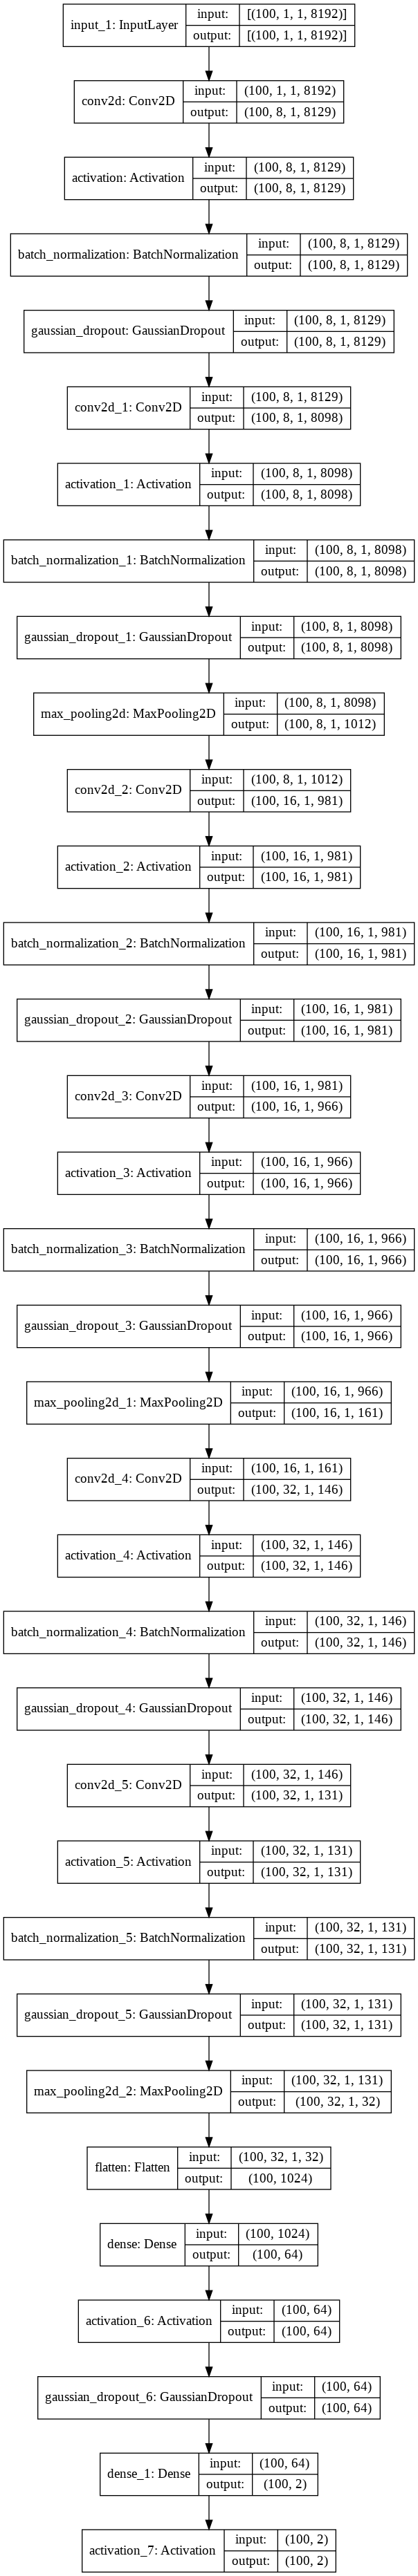

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Training

In [5]:
def fit_model(model, outdir, rho_opt, 
              x_train, y_train, x_val, y_val):
    
    y_categ = to_categorical(y_train, num_classes=2)
    y_categ_val = to_categorical(y_val, num_classes=2)

    earlyStopping = EarlyStopping(monitor='val_binary_crossentropy', patience=10, 
                                verbose=0, mode='auto')
    modelCheck = ModelCheckpoint('{0}best_weights_rho{1}.hdf5'.format(outdir, rho_opt), 
                                monitor='val_binary_crossentropy', verbose=0, save_best_only=True, 
                                save_weights_only=True, mode='auto', save_freq='epoch')
    n_epochs = 200
    print('Fitting model...')
    hist = model.fit(x_train[:,None,None,:], y_categ,
                    epochs=n_epochs,
                    validation_data=(x_val[:,None,None,:], y_categ_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[earlyStopping, modelCheck])
    return hist

#  hist = fit_model(model, x_train, y_train, x_val, y_val)

In [ ]:
hist.history

{'acc': [0.8067407608032227,
  0.9531037211418152,
  0.9590444564819336,
  0.9627037048339844,
  0.9652592539787292,
  0.9682444334030151,
  0.9692147970199585,
  0.9709036946296692,
  0.9730592370033264,
  0.97491854429245,
  0.977051854133606,
  0.9782296419143677,
  0.9798222184181213,
  0.9807111024856567,
  0.9823926091194153,
  0.9839925765991211,
  0.9842814803123474,
  0.9857333302497864,
  0.986392617225647,
  0.9866222143173218,
  0.9873185157775879,
  0.9883111119270325,
  0.988955557346344,
  0.9895259141921997],
 'binary_crossentropy': [0.3439122140407562,
  0.12706956267356873,
  0.11039882898330688,
  0.10232624411582947,
  0.09572013467550278,
  0.0884518101811409,
  0.08316071331501007,
  0.07932843267917633,
  0.07449474930763245,
  0.07043913751840591,
  0.06501976400613785,
  0.06121572479605675,
  0.05669130012392998,
  0.05336090922355652,
  0.04933357611298561,
  0.04604428634047508,
  0.044713664799928665,
  0.041110094636678696,
  0.03880941495299339,
  0.03871

In [13]:
print('Evaluating model...')
def evaluate_model(model, outdir, rho_opt, x_test, y_test):
    y_categ_test = to_categorical(y_test, num_classes=2)
    model.load_weights('{0}best_weights_rho{1}.hdf5'.format(outdir, rho_opt))
    eval_results = model.evaluate(x_test[:,None,None,:], y_categ_test,
                                sample_weight=None,
                                batch_size=batch_size, verbose=1)

    preds = model.predict(x_test[:,None,None,:])

    return preds, eval_results, y_categ_test



Evaluating model...


rho: 4
Loading Data...Done
Compiling model...
75/75 [==============================] - 1s 12ms/step - loss: 0.5928 - acc: 0.6785 - binary_crossentropy: 0.5928
rho: 8
Loading Data...Done
Compiling model...
75/75 [==============================] - 1s 9ms/step - loss: 0.0959 - acc: 0.9643 - binary_crossentropy: 0.0959


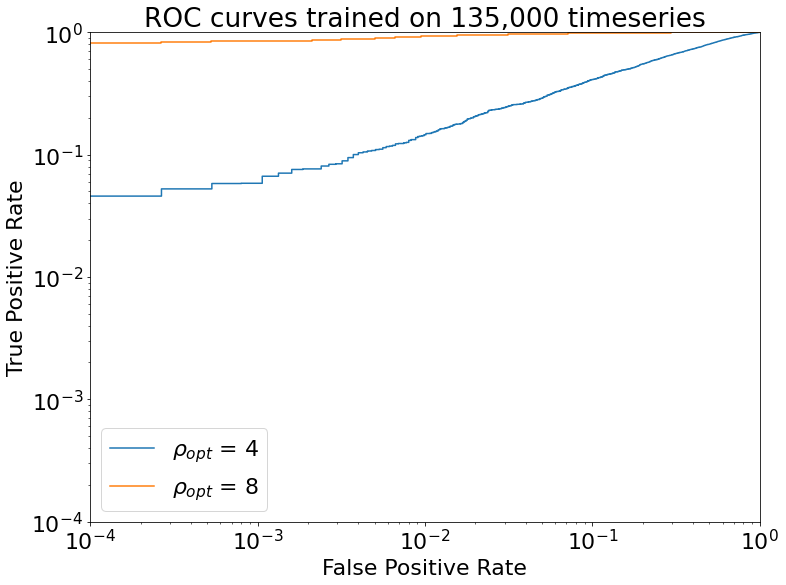

In [59]:
train_ratio = 0.90
validation_ratio = 0.05
test_ratio = 0.05
trials = 3
plt.figure(figsize=(12,9))
plt.title("ROC curves trained on 135,000 timeseries")
for rho_opt in [4, 8]:
    print("rho: {}".format(rho_opt))
    input_dir =  "drive/MyDrive/gw-nn-data/rho{}/".format(rho_opt)
    print("Loading Data...", end="")
    x_test, y_test = load_test(input_dir)
    print("Done")
    model = create_model()
    compile_model(model)
    outdir = input_dir
    preds, eval_results, y_categ_test = evaluate_model(model, outdir, rho_opt, 
                                                           x_test, y_test)
    fpr , tpr , thresholds = roc_curve (y_categ_test[:,0] , preds[:,0])
    
    plot_roc_curve(fpr, tpr, rho_opt)
plt.axis([1E-4,1,1E-4,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend()
plt.savefig("./drive/MyDrive/gw-nn-data/roc-curve-rho_4_8.png")

In [ ]:
preds

array([[6.6661380e-02, 9.3333864e-01],
       [9.8677501e-02, 9.0132242e-01],
       [7.4922200e-03, 9.9250776e-01],
       ...,
       [1.2142692e-02, 9.8785734e-01],
       [1.0000000e+00, 7.4021123e-09],
       [1.0000000e+00, 4.3336112e-09]], dtype=float32)

In [ ]:


fpr , tpr , thresholds = roc_curve ( y_categ_test[:,0] , preds[:,0])

In [16]:
def plot_roc_curve(fpr, tpr, rho_opt): 
  plt.loglog(fpr, tpr, label=r"$\rho_{{opt}}$ = {}".format(rho_opt)) 

#   plt.show()    
  
# plot_roc_curve(fpr,tpr)

rho: 8
Loading Data...Done
Compiling model...
Fitting model...
Epoch 1/200
4219/4219 [==============================] - 53s 13ms/step - loss: 0.1905 - acc: 0.9255 - binary_crossentropy: 0.1905 - val_loss: 0.1389 - val_acc: 0.9456 - val_binary_crossentropy: 0.1389
Epoch 2/200
4219/4219 [==============================] - 53s 13ms/step - loss: 0.1263 - acc: 0.9530 - binary_crossentropy: 0.1263 - val_loss: 0.1356 - val_acc: 0.9485 - val_binary_crossentropy: 0.1356
Epoch 3/200
4219/4219 [==============================] - 52s 12ms/step - loss: 0.1142 - acc: 0.9578 - binary_crossentropy: 0.1142 - val_loss: 0.1047 - val_acc: 0.9624 - val_binary_crossentropy: 0.1047
Epoch 4/200
4219/4219 [==============================] - 52s 12ms/step - loss: 0.1064 - acc: 0.9607 - binary_crossentropy: 0.1064 - val_loss: 0.1277 - val_acc: 0.9551 - val_binary_crossentropy: 0.1277
Epoch 5/200
4219/4219 [==============================] - 52s 12ms/step - loss: 0.0978 - acc: 0.9640 - binary_crossentropy: 0.0978 - v

{'rho8': <tensorflow.python.keras.callbacks.History at 0x7fe2b206cc88>}

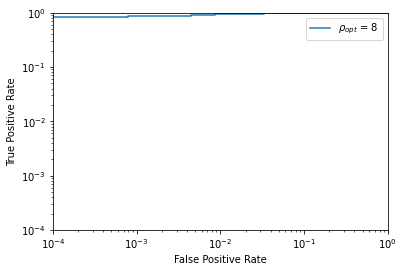

In [20]:
train_ratio = 0.90
validation_ratio = 0.05
test_ratio = 0.05
trials = 3
histories = {}
def run_analysis():
    for rho_opt in [8, ]:
        print("rho: {}".format(rho_opt))
        input_dir =  "drive/MyDrive/gw-nn-data/rho{}/".format(rho_opt)
        print("Loading Data...", end="")
        x_train, x_val, y_train, y_val = load_train_val(input_dir)
        print("Done")

        model = create_model()
        compile_model(model)

        outdir = input_dir
        histories["rho{}".format(rho_opt)] = fit_model(model, outdir, rho_opt,
                                                       x_train, y_train, 
                                                       x_val, y_val)
        del x_train, x_val, y_train, y_val
        x_test, y_test = load_test(input_dir)
        preds, eval_results, y_categ_test = evaluate_model(model, outdir, rho_opt, 
                                                           x_test, y_test)
        fpr , tpr , thresholds = roc_curve (y_categ_test[:,0] , preds[:,0])
        
        plot_roc_curve(fpr, tpr, rho_opt)
        
    plt.axis([1E-4,1,1E-4,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.legend()
    plt.savefig("./drive/MyDrive/gw-nn-data/roc-curve-rho_4_8.png")
    return histories

run_analysis() 

In [22]:
histories["rho8"].history

{'acc': [0.9254740476608276,
  0.9530370235443115,
  0.9578296542167664,
  0.9606666564941406,
  0.9640148282051086,
  0.9661259055137634,
  0.9685184955596924,
  0.9698370099067688,
  0.9713703989982605,
  0.9732296466827393,
  0.9743852019309998,
  0.975777804851532,
  0.9772074222564697,
  0.9785703420639038,
  0.9797777533531189,
  0.9811925888061523,
  0.9819333553314209],
 'binary_crossentropy': [0.19049949944019318,
  0.12627187371253967,
  0.11416395753622055,
  0.10641825199127197,
  0.09784100949764252,
  0.09227070212364197,
  0.08661122620105743,
  0.08209773898124695,
  0.07840711623430252,
  0.07375168055295944,
  0.07053907215595245,
  0.06589935719966888,
  0.06110578030347824,
  0.05837247148156166,
  0.05465439334511757,
  0.051294922828674316,
  0.048413898795843124],
 'loss': [0.19050148129463196,
  0.12627215683460236,
  0.1141643300652504,
  0.10642822831869125,
  0.09784134477376938,
  0.09227937459945679,
  0.08661353588104248,
  0.08209820836782455,
  0.0784674

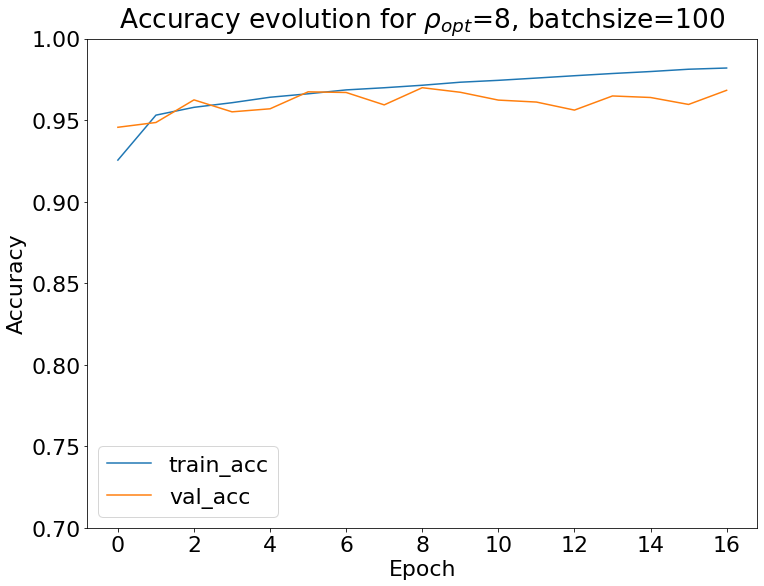

In [50]:
plt.figure(figsize=(12,9))
plt.plot(histories["rho8"].epoch,histories["rho8"].history["acc"], label="train_acc")
plt.plot(histories["rho8"].epoch,histories["rho8"].history["val_acc"], label="val_acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(r"Accuracy evolution for $\rho_{{opt}}$=8, batchsize={}".format(batch_size))
plt.ylim(0.7,1.0)
plt.savefig("./drive/MyDrive/gw-nn-data/rho8/accuracy_rho8.png");

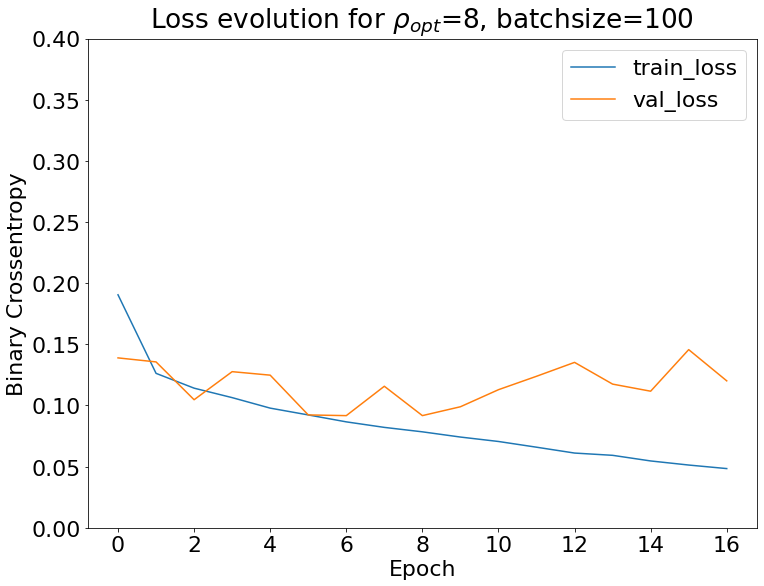

In [53]:
plt.figure(figsize=(12,9))
plt.plot(histories["rho8"].epoch,histories["rho8"].history["loss"], label="train_loss")
plt.plot(histories["rho8"].epoch,histories["rho8"].history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.title(r"Loss evolution for $\rho_{{opt}}$=8, batchsize={}".format(batch_size))
plt.ylim(0.0, 0.4)
plt.savefig("./drive/MyDrive/gw-nn-data/rho8/loss_rho8.png");